# PASO 0: IMPORTACIÓN DE LIBRERÍAS
Este análsis se realizó con el uso de [Facebook prophet](//facebook.github.io/prophet/docs/quick_start.html) libería de regresión que además de trazar regresiones lineales con los datos existentes considera estacionalidad, holiday


In [ ]:
!pip install --upgrade prophet cmdstanpy
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

##  😀 **Loading Historical Performance**



We are feeding the model our actual traffic data from Jan 1st to Oct 20th. This is our "ground truth." The quality of our forecast depends entirely on the accuracy of this historical data. But you could charge the data with the time period you like, download this data to GA4, and charge by CSV.
<br><br>
**IMPORTANT**
The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [ ]:
#carga de datos del tráfico desde 1 de enero hasta el 20 de octubre
df = pd.read_csv('/content/your-own-data.csv')
df.head()

,ds,y
0,1/1/2025,704
1,1/2/2025,1000
2,1/3/2025,852
3,1/4/2025,690
4,1/5/2025,715



## ✏️ **STEP 2: TRAINING THE MODEL & LOCALIZATION**
<br>


This is crucial. We are explicitly telling the AI two things:

* Market Cap: We are setting a logical growth ceiling (cap = 3000). This keeps the forecast realistic so we don't promise stakeholders infinite growth.

* Localization (Peru): By adding country_name='PE', the model knows that traffic will naturally drop on Peruvian holidays (like Independence Day or Battle of Angamos). This prevents false alarms when traffic dips on those days.

In [ ]:
# Aquí se establece el limite superior logico de crecimiento.
df['cap'] = 3000


In [ ]:
# Instanciamos el modelo.
# interval_width=0.95 significa que queremos un intervalo de confianza del 95% el intervalo de confianza por defecto es de 80%
m = Prophet(interval_width=0.95)


# Esto ayuda a que el modelo entienda por qué el tráfico baja en festivos en Perú
m.add_country_holidays(country_name='PE')

# Entrenamos el modelo con los datos históricos
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
import holidays

# Obtener festivos de Perú para los años que te interesan (ej. 2023, 2024, 2025)
# Prophet usa este mismo diccionario internamente
festivos_peru = holidays.PE(years=[ 2025])

# Imprimir la lista ordenada
for fecha, nombre in sorted(festivos_peru.items()):
    print(f"{fecha}: {nombre}")

2025-01-01: New Year's Day
2025-04-17: Maundy Thursday
2025-04-18: Good Friday
2025-04-20: Easter Sunday
2025-05-01: Labor Day
2025-06-07: Battle of Arica and Flag Day
2025-06-29: Saint Peter and Saint Paul's Day
2025-07-23: Peruvian Air Force Day
2025-07-28: Independence Day
2025-07-29: Great Military Parade Day
2025-08-06: Battle of Junín Day
2025-08-30: Rose of Lima Day
2025-10-08: Battle of Angamos Day
2025-11-01: All Saints' Day
2025-12-08: Immaculate Conception
2025-12-09: Battle of Ayacucho Day
2025-12-25: Christmas Day


## **📐 STEP 3: THE FORECAST**


We are asking the model to look 40 days into the future. This is perfect for end-of-year planning or preparing for the next quarterly review.

In [ ]:
# Le pedimos al modelo que cree un dataframe con los próximos 40 días para comprender como se cerrará el año
futuro = m.make_future_dataframe(periods=40)

# Realizamos la predicción
forecast = m.predict(futuro)

##🗓️  **STEP 4: VISUALIZATION (The Trend)**
<br>
This graph shows the story of our SEO efforts. The black dots are actuals; the blue line is the trend. If the blue line is moving up to the right, our strategy is working.


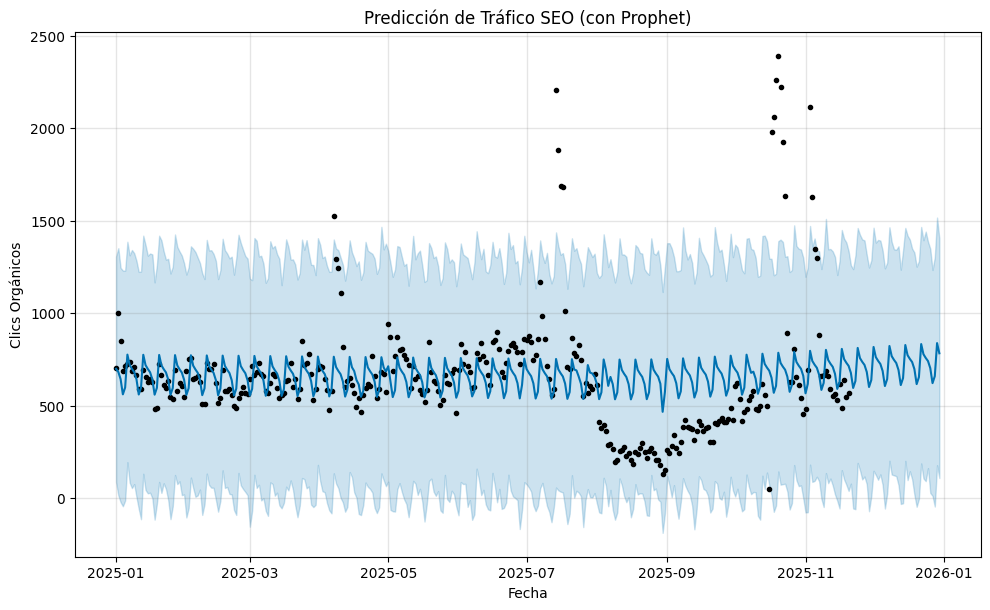

In [ ]:
# Gráfico principal
fig1 = m.plot(forecast)
plt.title("Predicción de Tráfico SEO (con Prophet)")
plt.xlabel("Fecha")
plt.ylabel("Clics Orgánicos")
plt.show()


## **STEP 5: TACTICAL VIEW (Daily Detail)**
The previous chart was strategic; this one is tactical. We are zooming in on the next few weeks. The ticks on the X-axis let us see exactly which weeks might be slow, allowing us to schedule content launches or email blasts to compensate for predicted dips.

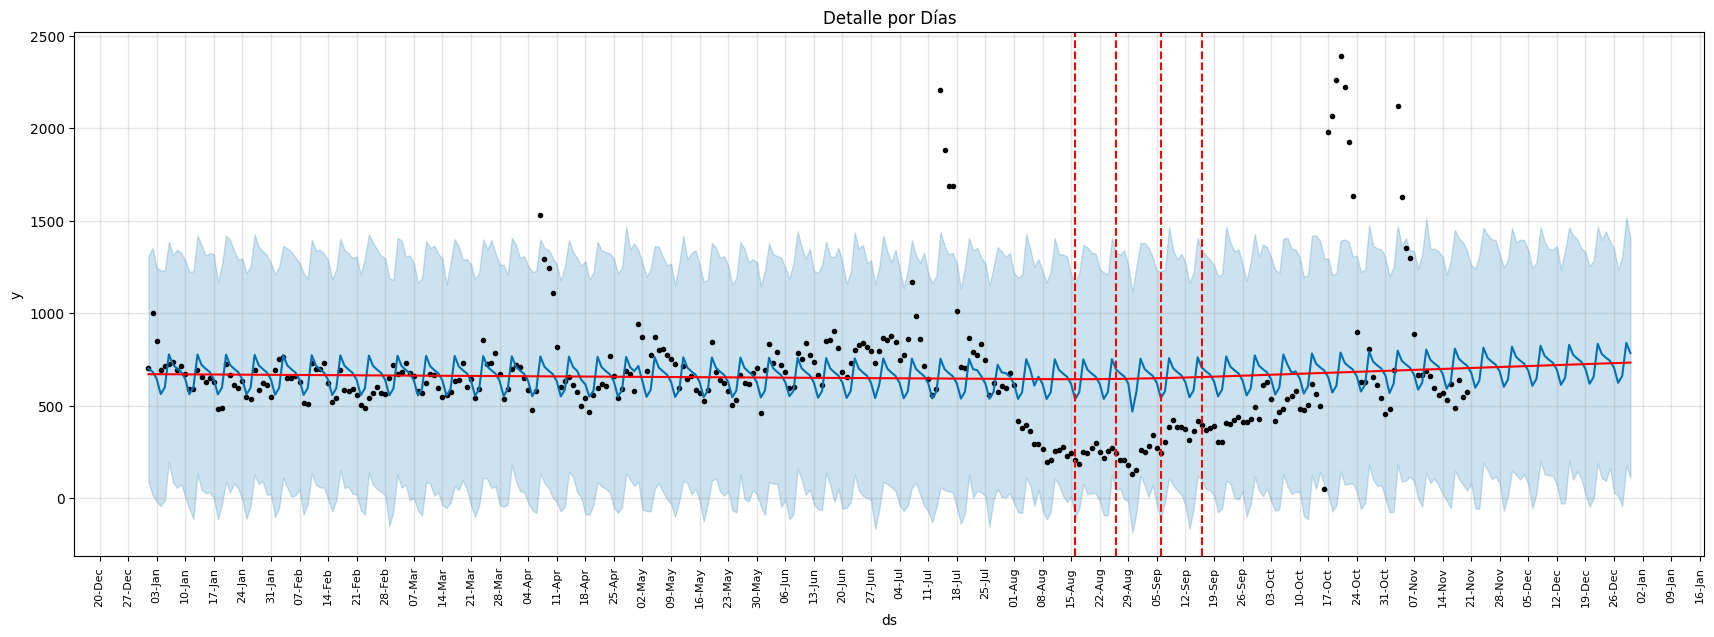

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Creamos el gráfico base
fig = m.plot(forecast)
ax = fig.gca()

# --- CONFIGURACIÓN PARA DÍAS ---

# A. Definir el intervalo de días
# interval=1  -> Muestra TODOS los días (Solo úsalo si filtras a 1 mes de datos)
# interval=7  -> Muestra una etiqueta cada semana (Ideal para 6 meses - 1 año)
# interval=15 -> Muestra una etiqueta cada quincena
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

# B. Formato de fecha: Día-Mes (Ej: "20-Oct")
# %d = día, %m = mes (número), %b = mes (abreviatura texto)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# C. Rotación de 90 grados (necesaria para que quepan las fechas verticales)
plt.xticks(rotation=90, fontsize=8)

# D. Ajustar tamaño para dar espacio
fig.set_size_inches(18, 6)

# (Opcional) E. Si quieres hacer ZOOM a un periodo específico para ver los días uno a uno:
# ax.set_xlim([pd.to_datetime('2025-08-01'), pd.to_datetime('2025-10-01')])

# -------------------------------

# 3. Añadimos changepoints y mostramos
from prophet.plot import add_changepoints_to_plot
add_changepoints_to_plot(ax, m, forecast)
plt.title("Detalle por Días")
plt.show()

## **STEP 6: COMPONENT ANALYSIS**
This is my favorite part for strategy. It breaks traffic down into behavior patterns:

* Trend: Is the brand growing overall?

* Weekly: Do users search more on Mondays vs. Sundays? (Helps with publishing schedules).

* Yearly: Is there a seasonal spike we need to prepare for?

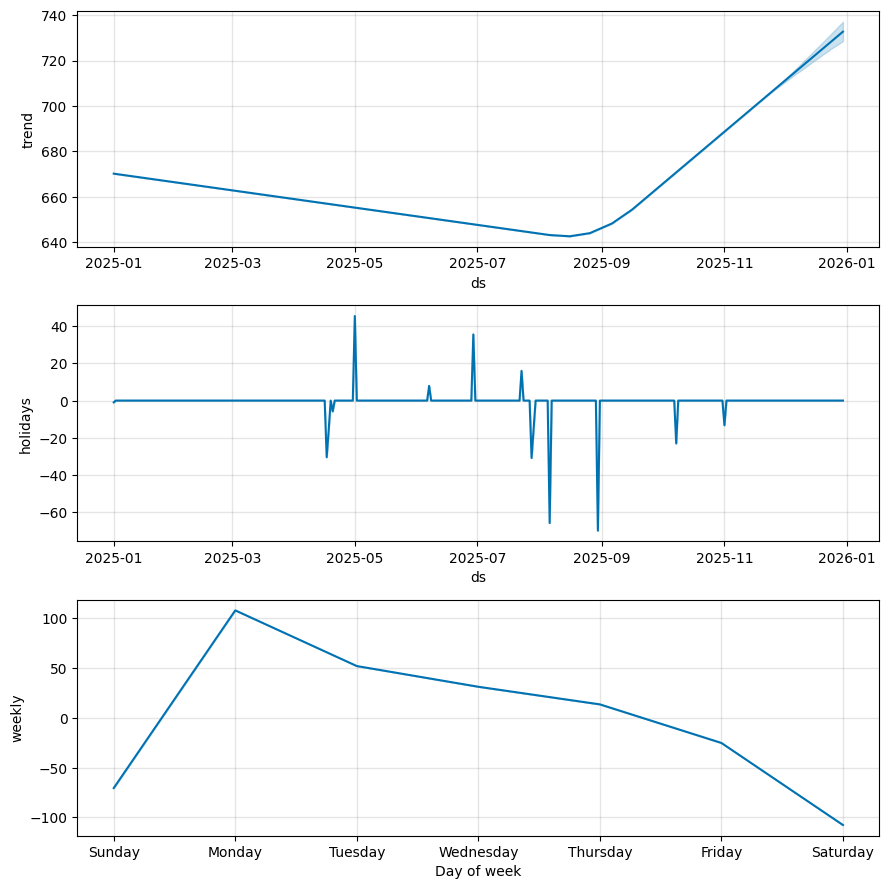

In [ ]:
# Gráfico de componentes (Tendencia, Semanal, Anual)
fig2 = m.plot_components(forecast)
plt.show()

## **STEP 7: SCENARIO PLANNING (The Table)**
This table is for risk management.

* Predicción (yhat): What we expect to happen.

* Mínimo (Lower): The "Worst Case" scenario. If we hit this, something is wrong.

*  Máximo (Upper): The "Best Case" scenario. If we hit this, we are viral or over-performing.

In [ ]:
# 1. Seleccionamos solo las columnas que nos importan
# ds = Fecha
# yhat = La predicción exacta
# yhat_lower = El escenario pesimista (mínimo)
# yhat_upper = El escenario optimista (máximo)
tabla_futura = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

# 2. (Opcional) Renombramos las columnas para que se entiendan mejor
tabla_futura = tabla_futura.rename(columns={
    'ds': 'Fecha',
    'yhat': 'Predicción',
    'yhat_lower': 'Mínimo Esperado',
    'yhat_upper': 'Máximo Esperado'
})

# 3. (Opcional) Redondeamos los decimales para que sea más limpio leerlo
tabla_futura = tabla_futura.round(0)

# 4. Ver la tabla en pantalla
print(tabla_futura)

         Fecha  Predicción  Mínimo Esperado  Máximo Esperado
354 2025-12-21       655.0              5.0           1296.0
355 2025-12-22       834.0            202.0           1468.0
356 2025-12-23       779.0            139.0           1397.0
357 2025-12-24       759.0             69.0           1398.0
358 2025-12-25       742.0             50.0           1363.0
359 2025-12-26       704.0             60.0           1353.0
360 2025-12-27       623.0            -18.0           1263.0
361 2025-12-28       661.0             52.0           1293.0
362 2025-12-29       839.0            229.0           1477.0
363 2025-12-30       784.0            136.0           1441.0
364 2025-12-31       764.0            109.0           1386.0
365 2026-01-01       747.0            103.0           1396.0
366 2026-01-02       710.0            109.0           1364.0
367 2026-01-03       628.0              6.0           1274.0
368 2026-01-04       666.0             80.0           1304.0
369 2026-01-05       845

## **STEP 8: GROWTH PROJECTION (KPIs)**
This is the number you put in the Executive Summary slide. We are projecting a 43.29% growth for the coming year compared to the trailing year. This validates that the SEO investment is yielding significant returns.

In [ ]:
# 1. Asegurarnos de que tenemos una predicción para todo el año siguiente
# Generamos 365 días a futuro (si no lo hiciste ya)
future_year = m.make_future_dataframe(periods=365)
forecast_year = m.predict(future_year)

# 2. Calcular el Total del Pasado (Últimos 365 días reales)
# Tomamos los últimos 365 datos de tu dataframe original 'df'
# OJO: Asumimos que tu 'df' tiene al menos 1 año de datos. Si tiene menos, compara promedios.
total_pasado = df['y'].tail(365).sum()

# 3. Calcular el Total del Futuro (Próximos 365 días predichos)
# Tomamos los últimos 365 días de la predicción
total_futuro = forecast_year['yhat'].tail(365).sum()

# 4. Calcular el Porcentaje de Crecimiento
crecimiento_pct = ((total_futuro / total_pasado) - 1) * 100

# 5. Mostrar resultados
print(f"--- PROYECCIÓN ANUAL ---")
print(f"Tráfico Real (Últimos 365 días): {total_pasado:,.0f}")
print(f"Tráfico Esperado (Próximos 365 días): {total_futuro:,.0f}")
print(f"------------------------")
print(f"Crecimiento Proyectado: {crecimiento_pct:.2f}%")

--- PROYECCIÓN ANUAL ---
Tráfico Real (Últimos 365 días): 213,679
Tráfico Esperado (Próximos 365 días): 306,173
------------------------
Crecimiento Proyectado: 43.29%
